In [1]:
import numpy as np
import time
import pandas as pd
from scipy.sparse import csr_matrix
from netreco import ss_sim
from netreco.ReconstructorLegacy import Profile, Reconstructor
import matplotlib.pyplot as plt

R = 100

In [2]:
A = [
    [0.75, 0, 0, 0, 0, 1.2],
    [-.1, -.35, 0, 0, 0, 0],
    [0, 0, .85, -1, 0, 0],
    [0, -.73, 0, .95, 0, 0],
    [0, 0, .43, 0, -.6, 0],
    [0, 0, 0, 0, .2, .55]

]
A = np.array(A)
B = [
    [1.4, 0, 0],
    [0, -.25, 0],
    [0, 0, 0.75],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
]
B = np.array(B)
C = [
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0]
]
C = np.array(C)

# u = pd.read_csv('../scripts/u.csv', header=None).values
u = np.random.rand(R * 6 + 1, 3)
y = ss_sim(A, B, C, u)

Pbool = np.identity(3)

recon = Reconstructor(debug=True)
# recon.measured(y, u, R, Pbool=Pbool, max_iterations=1000, bounds=3)

Setting up ...
	Done. Took 0.000 Seconds
Building LQ ...
	Done. Took 0.206 Seconds
Building M ...
	Done. Took 0.093 Seconds
Building yhat ...
	Done. Took 0.000 Seconds
Running Least Squares for yhat = M*xhat ...
	Finished in 500 iterations
	Done. Took 0.780 Seconds
Building Qi's ...
	Done. Took 0.001 Seconds


"\nfor i in range(recon.p):    \n    for j in range(recon.p):\n        recon._fit_conv(Qis, i, j)\n\nrecon.dprint('\nReconstruction Complete! Took {:.3f} Seconds\n'.format(\n    time.time() - beginning\n))\n"

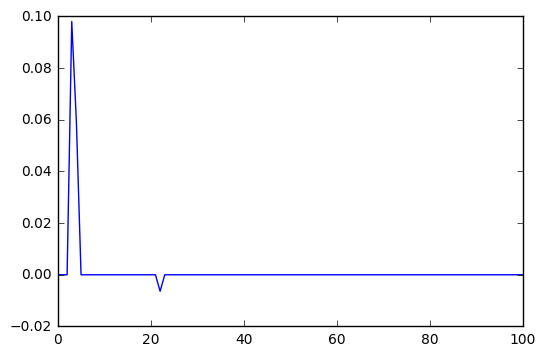

In [3]:
% matplotlib inline
r = R
kwargs = dict(Pbool=None, max_iterations=10, bounds=3, robust=True, criterion='bic')

beginning = time.time()

with Profile(recon.debug, 'Setting up'):
    recon.robust = kwargs.get('robust', False)
    recon.alpha = kwargs.get('alpha', 1)
    recon.T22 = kwargs.get('T22', None)
    recon.Pbool = kwargs.get('Pbool', None)
    recon.order = kwargs.get('order', 3)
    recon.bounds = kwargs.get('bounds', 10)
    recon.test_params = kwargs.get('test_params', False)
    recon.criterion = kwargs.get('criterion', 'aic')

    if recon.test_params:
        recon.max_iterations = 1
    else:
        recon.max_iterations = kwargs.get('max_iterations', 10)

    f, p = y.shape
    # f1, m = u.shape

    # assert f == f1
    # assert not (recon.Pbool is None and recon.T22 is None)

    recon.p = p
    # recon.m = m
    recon.f = f

    r = min(r, f - 1)
    recon.r = r

with Profile(recon.debug, 'Building LQ'):
    rows, cols, data = recon._build_LQ(y)
    # LQ = csr_matrix((np.concatenate(data),
    #                  (np.concatenate(rows),
    #                   np.concatenate(cols))
    #                  ),
    #                 ((recon.f - 1) * recon.p,
    #                  recon.r * (recon.p * recon.p - recon.p)))
    # print(LQ.shape)
    # print(LQ.toarray())
    
with Profile(recon.debug, 'Building M'):
    M = csr_matrix((np.concatenate(data),
                    (np.concatenate(rows),
                     np.concatenate(cols))
                    ),
                   ((recon.f - 1) * recon.p,
                    recon.r * (recon.p * recon.p - recon.p)))

with Profile(recon.debug, 'Building yhat'):
    yhat = recon._build_yhat(y)

with Profile(recon.debug, 'Running Least Squares for yhat = M*xhat'):
    xhat = recon._run_lsq(M, yhat)

with Profile(recon.debug, 'Building Qi\'s'):
    Qis = recon._extract_Qis(xhat)

plt.figure()
plt.plot(list(range(recon.r + 1)), Qis[0][2])

"""
for i in range(recon.p):    
    for j in range(recon.p):
        recon._fit_conv(Qis, i, j)

recon.dprint('\nReconstruction Complete! Took {:.3f} Seconds\n'.format(
    time.time() - beginning
))
"""

In [4]:
def fiterr(params, act, plot=False):
    n = len(act)
    exp = np.zeros(n)
    for t in range(1, n):
        for i in range(int(len(params) / 2)):
            exp[t] += params[i * 2] * params[i * 2 + 1] ** t
            
    err = abs(np.array(act) - exp)
    if plot:
        plt.figure()
        plt.plot(range(n), act)
        plt.plot(range(n), exp)
        plt.title('Exp (b) vs Act (g)')
    
        plt.figure()
        plt.plot(range(n), err)
        plt.title('Errors')
        
    toterr = sum(err)
    # print(toterr)
    return toterr
    
with Profile(True, 'fit'):
    err = fiterr([0.118, 0.867, -.776, -.401, 3, -.136], Qis[0][2])
    print(err)
    err = fiterr([0, 0, 0, 0, 0, 0], Qis[0][2])
    print(err)
    err = fiterr([.51, .75, -.11, -.6, -.816, .55], Qis[0][2])
    print(err)

fit ...
0.504224394071
0.163424582951
0.423847497788
	Done. Took 0.002 Seconds


     fun: 7.9654833554935465
     jac: array([ -0.16,   1.85,  -0.19,  -2.18,   0.04,  21.94,  -0.05, -20.61])
 message: 'Optimization terminated successfully.'
    nfev: 19824
     nit: 148
 success: True
       x: array([-3.86,  0.21,  7.27,  0.28, -9.56,  0.82,  7.  ,  0.94])


7.965483355493542

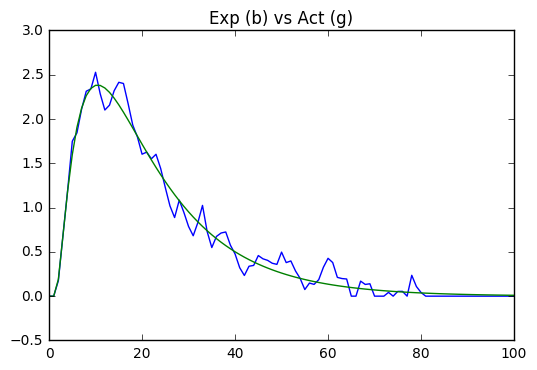

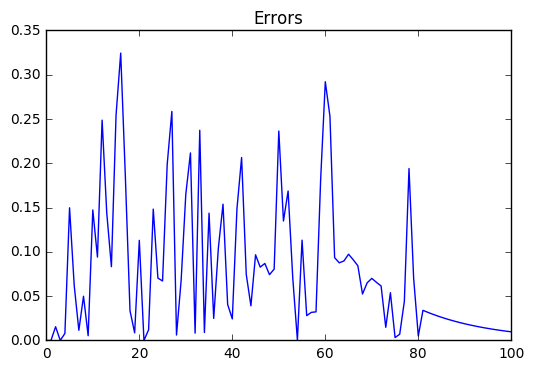

In [11]:
from scipy.optimize import differential_evolution
from functools import partial

obj = partial(fiterr, act=Qis[2][1])

rs = differential_evolution(obj, bounds=[(-10, 10), (-1, 1), (-10, 10), (-1, 1), (-10, 10), (-1, 1), (-10, 10), (-1, 1)])
print(rs)
fiterr(rs.x, Qis[2][1], True)

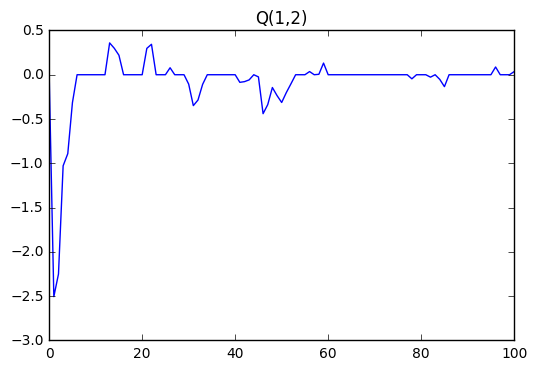

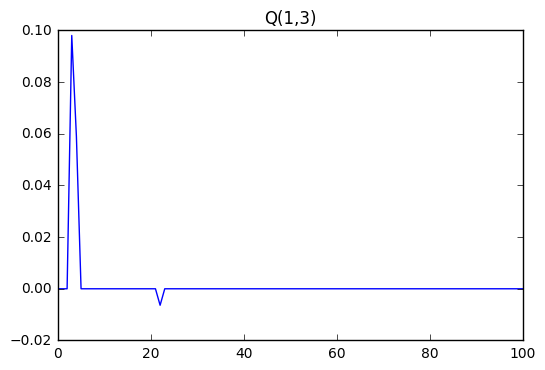

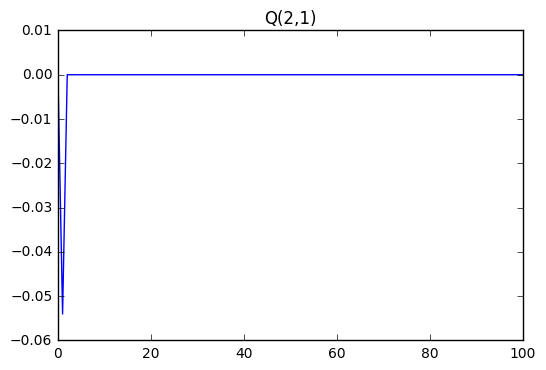

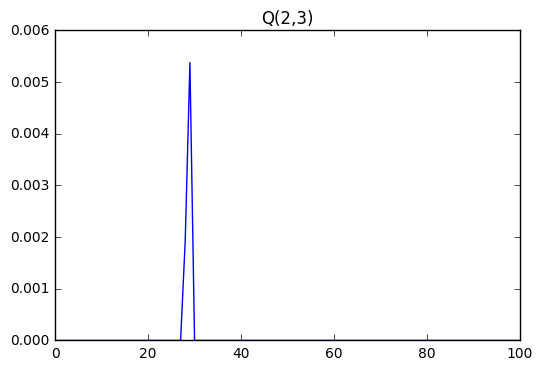

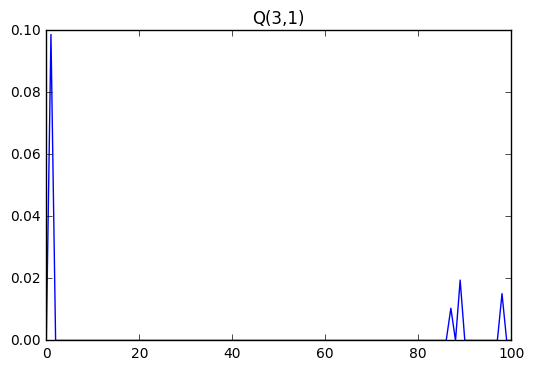

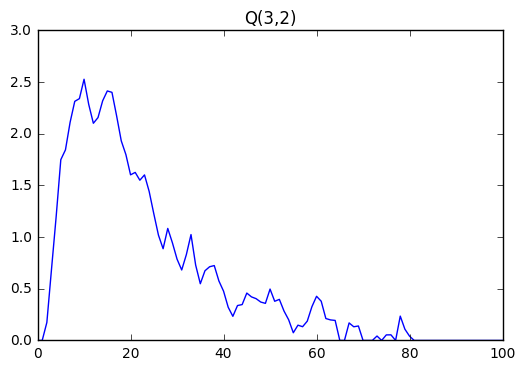

In [9]:
%matplotlib inline
for i in range(3):
    for j in range(3):
        if i == j:
            continue
        plt.figure()
        plt.plot(list(range(R + 1)), Qis[i][j])
        plt.title('Q({},{})'.format(i + 1, j + 1))
        plt.show()